# Visualizer
### Use this script to visualize the neuron traces according to the paper "A Generalized Linear Integrate-and-Fire Neural Model Produces Diverse Spiking Behaviors" by Stefan Mihalas and Ernst Niebur. Further, data was created with a fix length of 1sec (1ms time steps), with noise on the input current, and/or temporal jitter on the time point of the step for dynamic inputs. 

### The script will also calculate the inter-spike intervalls (ISIs) for a single trial and for all repeating trials, whenever possible. For repeating trials, all ISIs are grouped and further statics represent the outcome of all repetitions per class.

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly

from tactile_encoding.utils.utils import value2key, create_directory


C:\Users\smuel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
max_trials = 100

classes_list = {
    'A': "Tonic spiking",
    'B': "Class 1",
    'C': "Spike frequency adaptation",
    'D': "Phasic spiking",
    'E': "Accommodation",
    'F': "Threshold variability",
    'G': "Rebound spike",
    'H': "Class 2",
    'I': "Integrator",
    'J': "Input bistability",
    'K': "Hyperpolarizing spiking",
    'L': "Hyperpolarizing bursting",
    'M': "Tonic bursting",
    'N': "Phasic bursting",
    'O': "Rebound burst",
    'P': "Mixed mode",
    'Q': "Afterpotentials",
    'R': "Basal bistability",
    'S': "Preferred frequency",
    'T': "Spike latency",
}


In [3]:
def return_isi_fix_len(data, max_trials, norm_count=False, norm_time=False):
    """
    Calculates and returns the ISI for all repetitions of fix length data.
    """
    isi_list = []
    for num, el in enumerate(list(classes_list.values())):
        # print(el)
        # concatenate all ISIs
        isi_fix_len = []
        for trial in range(max_trials):
            # calc spikes per trial
            spikes = np.reshape(np.array(data[trial + num*max_trials][0]), (np.array(
                data[trial + num*max_trials][0]).shape[0]))
            # calc ISI
            isi_fix_len.extend(np.diff(np.where(spikes == 1)[0]))

        if len(isi_fix_len) > 0:
            tmp_fix_len = np.unique(isi_fix_len, return_counts=True)
            isi_fix_len = tmp_fix_len[0]
            if norm_time:
                isi_fix_len = isi_fix_len/max(isi_fix_len)
            isi_fix_len_count = tmp_fix_len[1]
            if norm_count:
                isi_fix_len_count = isi_fix_len_count/max(isi_fix_len_count)
            # create 2d array
            isi = np.vstack([isi_fix_len, isi_fix_len_count])
        isi_list.append(isi)

    return isi_list

### NTE - Tactile encoding

In [4]:
import torch
import os

In [5]:
data_path_braille = './data/braille_mn_output'  # path to load data
data_path_original = './data/original_mn_output'
plot_out = './plots'
# neuron parameters
a: 2.743
A1: 0.03712
A2: -0.5089
b: 11.4
G: 47.02
k1: 200
k2: 20
R1: 0
R2: 1


In [15]:
# TODO check if ALL data from batches are extracted and extented -> final numper of ISI is too low
file_names = os.listdir(data_path_braille)
file_names = np.sort(file_names)
isi_list = []
isi_dict = {}
for entry in range(27):
    isi_dict[entry] = []
for _, file_name in enumerate(file_names):
    # print(file_name)
    # only look at test
    if 'test' in file_name:
        [mn_spk, input_current, trial_label] = torch.load(
            data_path_braille + '/' + file_name, map_location=torch.device('cpu'))
        # convert to numpy
        mn_spk = mn_spk.numpy()
        input_current = input_current.numpy()
        trial_label = trial_label.numpy()

        # mn_spk.shape: [batch_size, time_steps, channels]
        # print(mn_spk.shape)
        # print(len(trial_label))  # one label per batch
        # print(np.unique(trial_label))
        # isi_dict = {}
        # for _, entry in enumerate(np.unique(trial_label)):
        #     isi_dict[entry] = []
        # print(isi_dict[0])
        # extract traces from single batch
        for batch in range(mn_spk.shape[0]):
            # print('Batch: ', batch)
            # TODO find all trials with same label and concatenate ISIs!!!!!
            # print('Trial label: ', trial_label[batch])
            # print('Data shape in batch: ', mn_spk[batch].shape)
            # print('Number of spikes per channel over time: ',
            #       np.sum(mn_spk[batch], axis=0))  # sum along time
            # print('Total number of spikes in batch: ',
            #       np.sum(mn_spk[batch]))  # total sum

            isi_list = []
            # channels_list = np.where(np.sum(mn_spk[batch], axis=0) > 1)
            # print('Channel list: ', channels_list)
            # for _, channel in enumerate(channels_list[0]):
            # loop over all channels
            # print(mn_spk[batch].shape)
            for channel in range(mn_spk[batch].shape[-1]):
                print('Channel: ', channel)
                print('Nbr spikes per channel: ', sum(mn_spk[batch][:, channel]))
                # print('Spike samples: ', np.where(mn_spk[batch][:, channel]==1.0))
                # print('ISIs: ', np.diff(np.where(mn_spk[batch][:, channel]==1.0))*1E-2)
                # calc ISI if at least 2 spikes found
                if np.sum(mn_spk[batch][:, channel]) > 1:
                    # print('Calc ISI. Spikecount: ', np.sum(mn_spk[batch][:, channel]))
                    isi_channel = np.diff(
                        np.where(mn_spk[batch][:, channel] == 1.0))*1E-2

                    # count ISIs and normalize in count and time
                    # returns member and count
                    unique_isi = np.unique(isi_channel, return_counts=True)
                    isi_braille = unique_isi[0]
                    # if norm_time:
                    #     isi_braille = isi_braille/max(isi_braille)
                    isi_braille_count = unique_isi[1]
                    # if norm_count:
                    #     isi_braille_count = isi_braille_count / \
                    #         max(isi_braille_count)
                    isi = np.vstack([isi_braille, isi_braille_count])
                else:
                    # print('Spikecount < 2.')
                    isi = [[], []]
                isi_list.append(isi)
                # print(isi, isi_braille, isi_braille_count)
            # print('ISI dict before:', isi_dict[trial_label[batch]])
            # print('len dict before: ', len(isi_dict[trial_label[batch]]))

            # init dict per label
            if len(isi_dict[trial_label[batch]]) < 1:
                # working
                # print('INIT')
                isi_dict[trial_label[batch]] = isi_list
            # extend dict
            else:
                # print('EXTEND')
                # extend the dict for each channel
                for entry in range(len(isi_dict[trial_label[batch]])):
                    # skip if nothing
                    # if len(isi_dict[trial_label[batch]][entry][0]) > 1.0:
                        # print('isi_dict[trial_label[batch]][entry]: ', isi_dict[trial_label[batch]][entry])
                        # print('len(isi_dict[trial_label[batch]][entry]): ', len(isi_dict[trial_label[batch]][entry]))
                        # print('len(isi_dict[trial_label[batch]][entry][0]): ', len(isi_dict[trial_label[batch]][entry][0]))
                        
                        # print('isi_list[entry]: ', isi_list[entry])
                        # print('len(isi_list[entry]): ', len(isi_list[entry]))
                        # print('len(isi_list[entry][0]): ', len(isi_list[entry][0]))
                    print('Class: ', entry)
                    print(len(isi_dict[trial_label[batch]][entry][0]), len(isi_list[entry][0]))
                    isi_dict[trial_label[batch]][entry] = np.append(isi_dict[trial_label[batch]][entry], isi_list[entry], axis=1)
                    print(len(isi_dict[trial_label[batch]][entry][0]))
                    print('\n')
            # print('len dict after: ', len(isi_dict[trial_label[batch]]))


Channel:  0
Nbr spikes per channel:  0.0
Channel:  1
Nbr spikes per channel:  0.0
Channel:  2
Nbr spikes per channel:  0.0
Channel:  3
Nbr spikes per channel:  40.0
Channel:  4
Nbr spikes per channel:  9.0
Channel:  5
Nbr spikes per channel:  0.0
Channel:  6
Nbr spikes per channel:  0.0
Channel:  7
Nbr spikes per channel:  0.0
Channel:  8
Nbr spikes per channel:  0.0
Channel:  9
Nbr spikes per channel:  0.0
Channel:  10
Nbr spikes per channel:  38.0
Channel:  11
Nbr spikes per channel:  0.0
Channel:  12
Nbr spikes per channel:  101.0
Channel:  13
Nbr spikes per channel:  2.0
Channel:  14
Nbr spikes per channel:  0.0
Channel:  15
Nbr spikes per channel:  0.0
Channel:  16
Nbr spikes per channel:  0.0
Channel:  17
Nbr spikes per channel:  0.0
Channel:  18
Nbr spikes per channel:  0.0
Channel:  19
Nbr spikes per channel:  0.0
Channel:  20
Nbr spikes per channel:  28.0
Channel:  21
Nbr spikes per channel:  0.0
Channel:  22
Nbr spikes per channel:  0.0
Channel:  23
Nbr spikes per channel:  0

KeyboardInterrupt: 

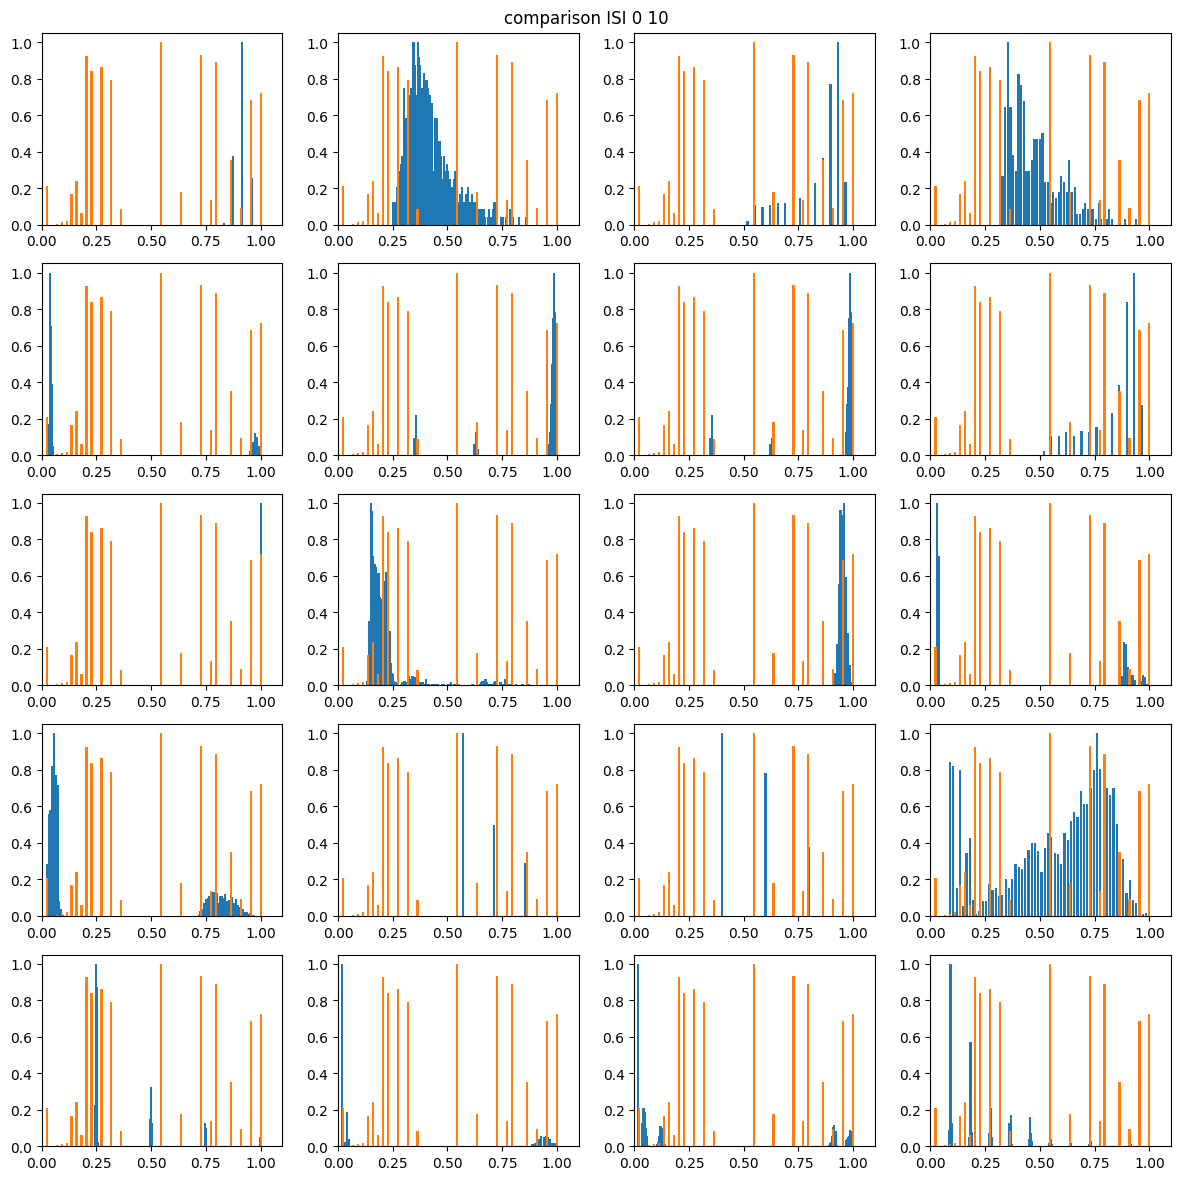

In [7]:
# load ISIs from paper
norm_count = True
norm_time = True
# data_types = ['', '_noisy', '_temp_jitter', '_noisy_temp_jitter']
filename = 'data_encoding_fix_len_noisy_temp_jitter'
infile = open(f"{data_path_original}/{filename}.pkl", 'rb')
data_original = pickle.load(infile)
infile.close()
isi_original = return_isi_fix_len(
    data_original, max_trials, norm_count=norm_count, norm_time=norm_time)

for _, entry in enumerate(isi_dict):
    # iterate over channel
    for channel in range(len(isi_dict[entry])):
        # print('ISI: ', isi_dict[entry][channel][0])
        # print('Count: ', isi_dict[entry][channel][1])
        # print('Unique and count: ', np.unique(isi_dict[entry][channel][0], return_index=True))
        isi, count = np.unique(isi_dict[entry][channel][0], return_index=True)
        # only plot if spikes found in channel
        if len(isi) > 0:
            if norm_time:
                isi = isi/max(isi)
            if norm_count:
                count = count/max(count)

            figname = f'comparison ISI {entry} {channel}'
            plt.figure(figsize=(12, 12))
            plt.suptitle(figname)
            # compare to original traces
            for num, isi_original_sel in enumerate(isi_original):
                plt.subplot(5, 4, num+1)
                # if len(isi) > 1:
                if norm_time:
                    plt.bar(isi_original_sel[0], isi_original_sel[1], width=0.01)
                    plt.bar(isi, count, width=0.01)
                else:
                    plt.bar(isi_original_sel[0], isi_original_sel[1])
                    plt.bar(isi, count)
                plt.xlim((0, 1.1))
                # else:
                #     plt.text(0.3, 0.5, 'Nope')
            plt.tight_layout()
            plt.savefig(f'{plot_out}/comparison_class_{entry}_channel_{channel}.png', dpi=300)
            plt.close()
            # plt.show()


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.